# Sierra Negra volcano, Ecuador - Topography

This is a topography point cloud of the 2018 lava flows of the Sierra Negra
volcano, located on the Galápagos islands, Ecuador.
The data are generated using structure from motion (SFM) and shows nice
topographic features and different roughness of the lava flows.
Good to show examples of calculating slope and other terrain properties from
the point cloud or gridded data.

**Source:** [Carr, B. (2020). Sierra Negra Volcano (TIR Flight 3): Galápagos, Ecuador, October 22 2018. Distributed by OpenTopography.](https://doi.org/10.5069/G957196P)

**License:** [CC-BY](https://doi.org/10.5069/G957196P)

## Notes

Data are in LAZ format and the horizontal coordinates are in WGS 84 / UTM zone 15S (EPSG: 32715). No mention of the vertical datum.

Useful reference for previous work done with this dataset:

> Carr, B. B., Lev, E., Sawi, T., Bennett, K. A., Edwards, C. S., Soule, S. A., et al. (2021, October). Mapping and classification of volcanic deposits using multi-sensor unoccupied aerial systems. Remote Sensing of Environment. Elsevier BV. https://doi.org/10.1016/j.rse.2021.112581 

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pyproj
import pygmt
import pooch
import laspy 

## Download the data

Use [Pooch](https://github.com/fatiando/pooch) to download the original data file to our computer.

In [2]:
fname = pooch.retrieve(
    url="https://opentopography.s3.sdsc.edu/dataspace/OTDS.092020.32715.4/pointcloud/Galapagos_TI_F3.laz",
    known_hash="md5:3871f9040c320cb194a99ef3615eea20",
)
print(f"size: {os.path.getsize(fname) / 1e6} Mb")

size: 32.845364 Mb


## Read the data

Use laspy to read in the data from the file. We'll read it in chunks and only take the ground reflection points to avoid overloading our memory.

In [3]:
easts, norths, heights = [], [], []
with laspy.open(fname) as lasfile:
    for chunk in lasfile.chunk_iterator(100_000):
        easts.append(chunk.x.scaled_array().copy())
        norths.append(chunk.y.scaled_array().copy())
        heights.append(chunk.z.scaled_array().copy())
data_full = pd.DataFrame({
    "easting": np.concatenate(easts),
    "northing": np.concatenate(norths),
    "elevation_m": np.concatenate(heights),
})
data_full

,easting,northing,elevation_m
0,710035.83,9913162.17,885.18
1,710035.73,9913161.74,885.36
2,710036.31,9913161.77,885.48
3,710036.34,9913162.23,885.49
4,710037.36,9913162.24,885.46
...,...,...,...
4895814,709458.62,9913881.10,929.15
4895815,709463.90,9913880.20,929.45
4895816,709465.43,9913878.79,929.70
4895817,709461.00,9913880.77,929.60


## Cut the data

Slice the data to a smaller section to avoid having too large a dataset. This is close to what was used in the paper referenced above.

In [4]:
inside = vd.inside((data_full.easting, data_full.northing), region=(709300, 709700, 9913400, 9913800))
data = data_full[inside].reset_index(drop=True)
data

,easting,northing,elevation_m
0,709699.44,9913400.95,930.05
1,709698.66,9913401.62,930.69
2,709699.71,9913401.16,930.30
3,709698.89,9913400.82,929.66
4,709699.07,9913400.30,929.18
...,...,...,...
1731379,709391.09,9913524.84,990.69
1731380,709404.25,9913525.95,990.24
1731381,709398.29,9913521.69,992.43
1731382,709398.57,9913525.12,991.22


## Convert UTM to latitude, longitude

Undo the projection and store the latitude, longitude so we don't need to preserve the UTM zone information.

In [5]:
wgs84 = pyproj.CRS.from_epsg(4326)
utm = pyproj.CRS.from_epsg(32715)
transformer = pyproj.Transformer.from_crs(utm, wgs84, always_xy=True)

In [6]:
data["longitude"], data["latitude"] = transformer.transform(data.easting, data.northing)
data

,easting,northing,elevation_m,longitude,latitude
0,709699.44,9913400.95,930.05,-91.115651,-0.783062
1,709698.66,9913401.62,930.69,-91.115658,-0.783056
2,709699.71,9913401.16,930.30,-91.115649,-0.783060
3,709698.89,9913400.82,929.66,-91.115656,-0.783063
4,709699.07,9913400.30,929.18,-91.115655,-0.783068
...,...,...,...,...,...
1731379,709391.09,9913524.84,990.69,-91.118421,-0.781943
1731380,709404.25,9913525.95,990.24,-91.118303,-0.781933
1731381,709398.29,9913521.69,992.43,-91.118357,-0.781971
1731382,709398.57,9913525.12,991.22,-91.118354,-0.781940


## Plot the data 

Make a quick plot to make sure the data look OK. This plot will be used as a preview of the dataset. There is quite a bit of data so we'll do a block median first to avoid overloading GMT.

In [7]:
blockmedian = vd.BlockReduce(np.median, spacing=0.05 / 3600)
coordinates, elevation = blockmedian.filter((data.longitude, data.latitude), data.elevation_m)

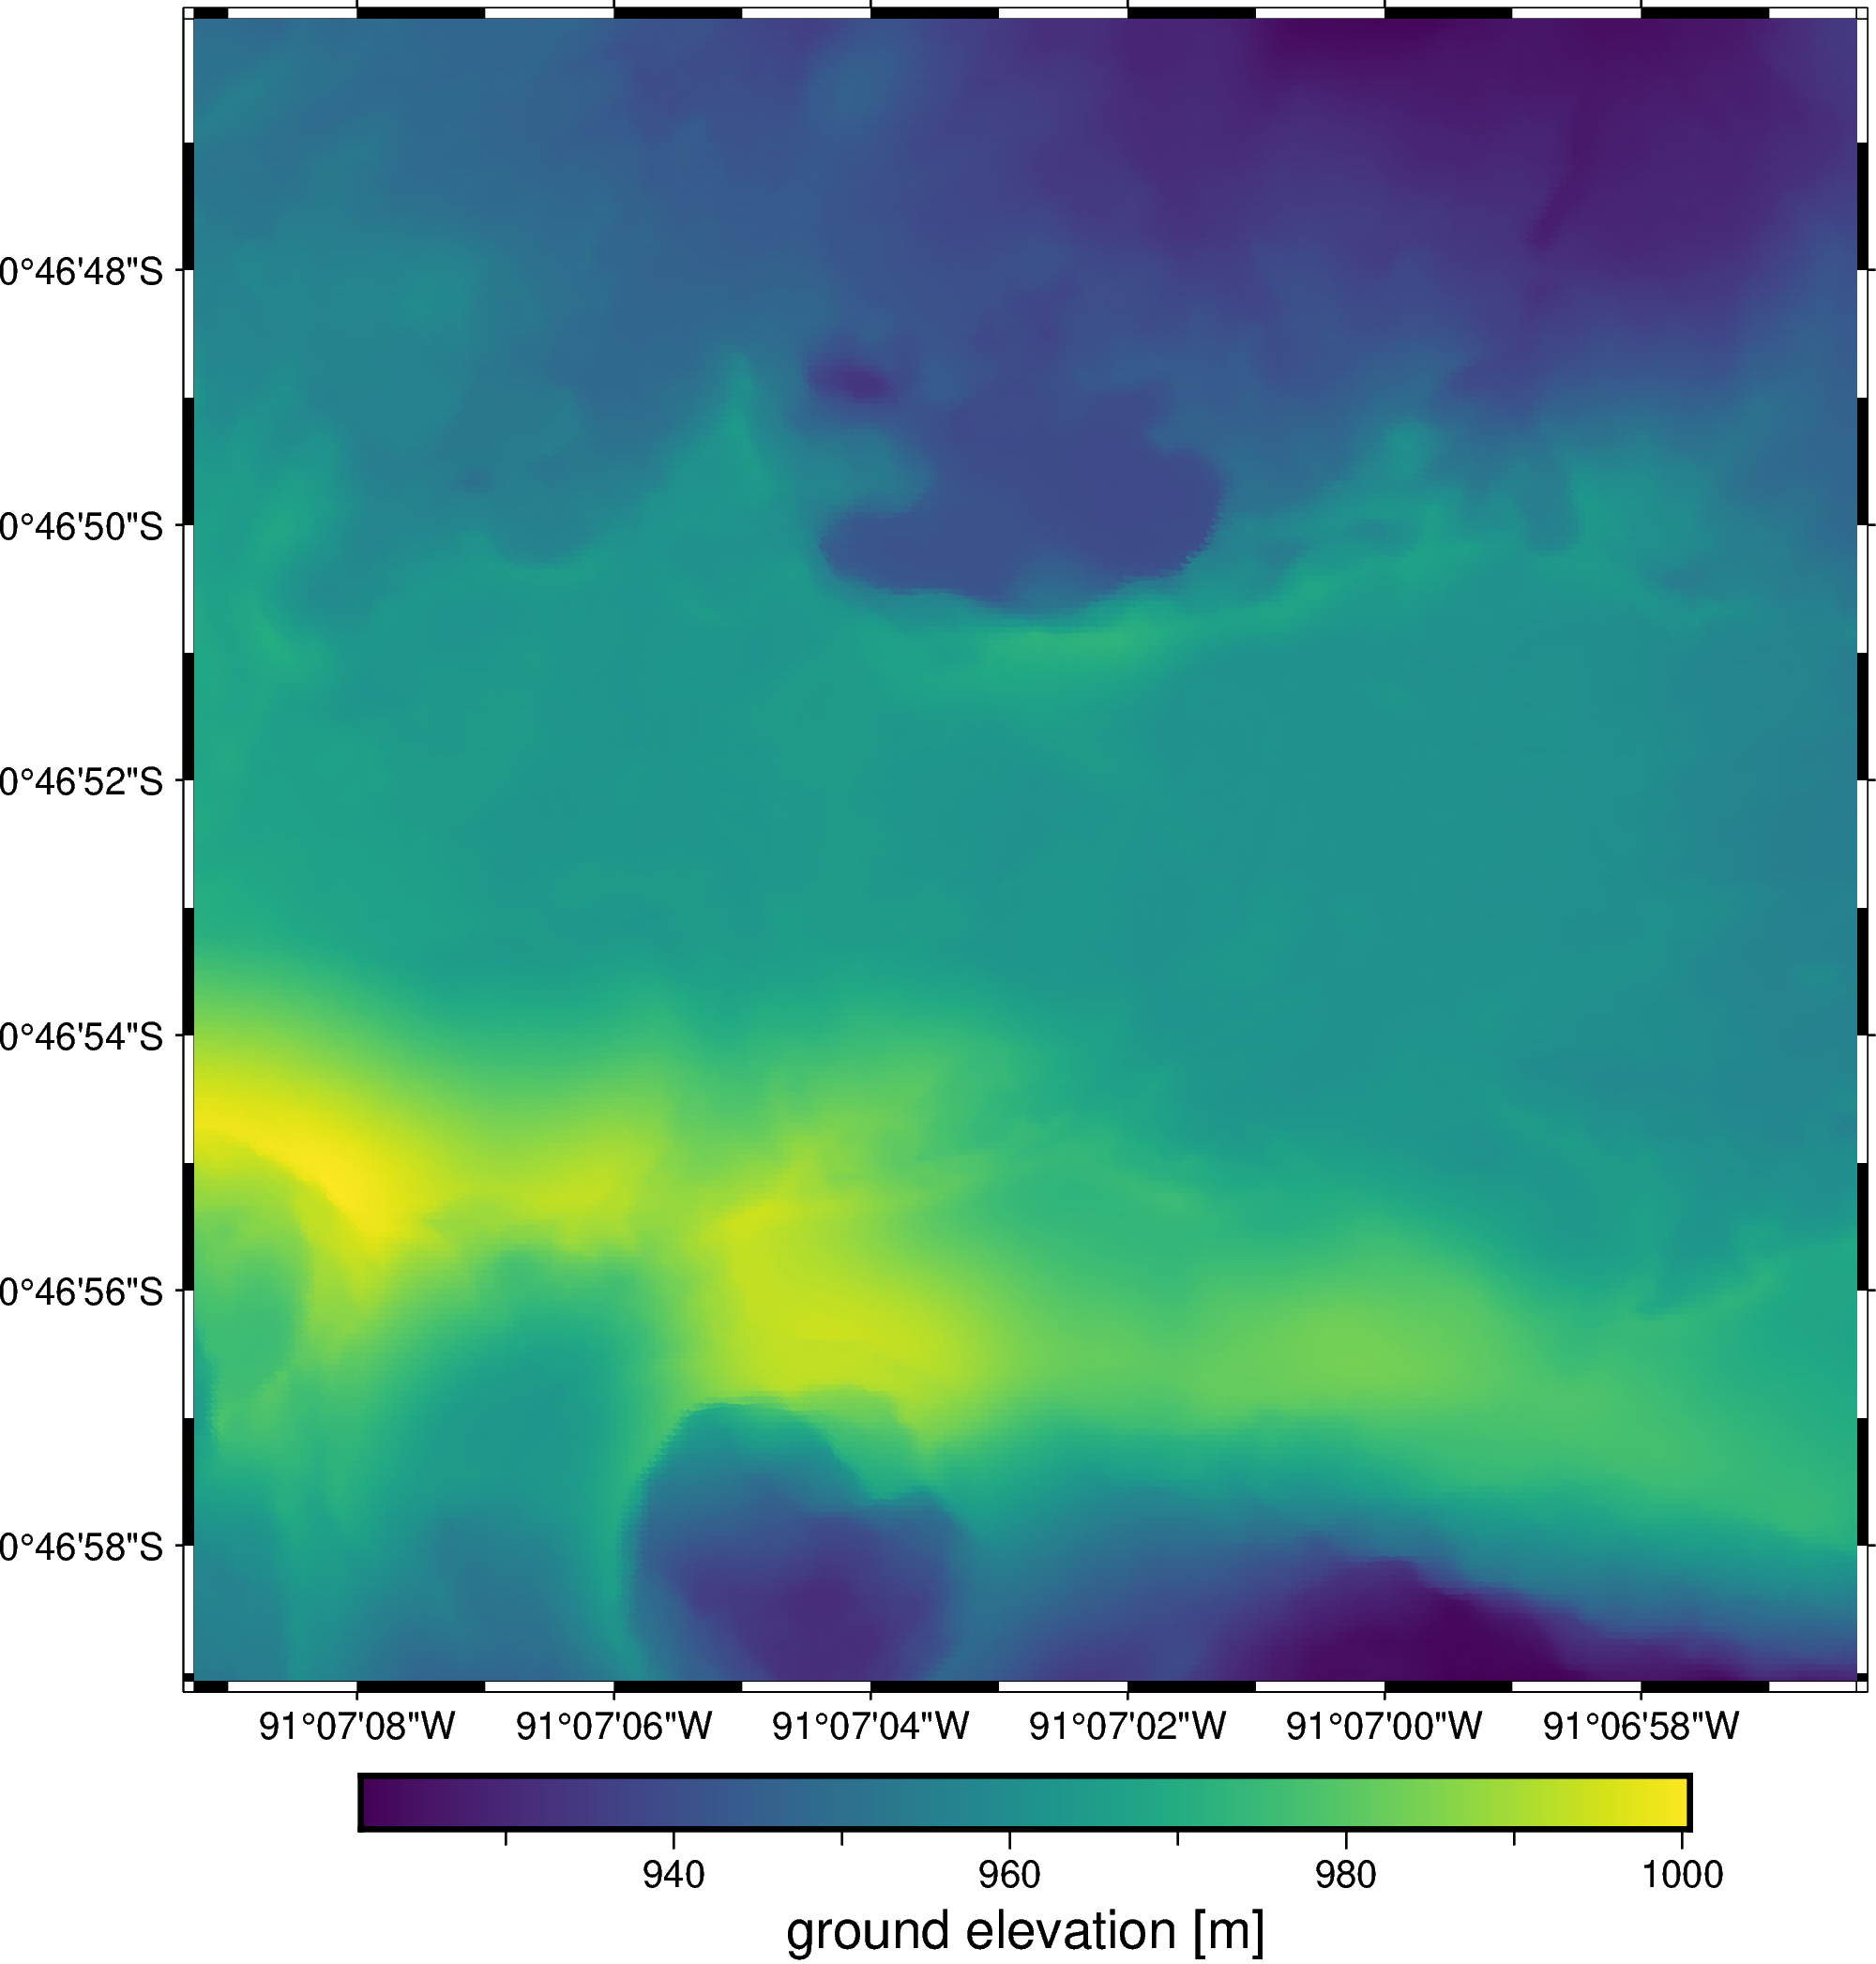

In [8]:
region = vd.get_region((data.longitude, data.latitude))

fig = pygmt.Figure()
fig.basemap(region=region, projection="M15c", frame=True)
pygmt.makecpt(cmap="viridis", series=[data.elevation_m.min(), data.elevation_m.max()])
fig.plot(
    x=coordinates[0], 
    y=coordinates[1], 
    color=elevation, 
    cmap=True, 
    style="c0.1c",
)
fig.colorbar(frame='af+l"ground elevation [m]"')
fig.savefig("preview.jpg", dpi=200)
fig.show()

## Export

Make a separate DataFrame to export to a compressed CSV. The conversion is needed to specify the number of significant digits to preserve in the output. Setting this along with the LZMA compression can help reduce the file size considerably. Not all fields in the original data need to be exported.

In [9]:
export = pd.DataFrame({
    "longitude": data.longitude.map(lambda x: "{:.7f}".format(x)),
    "latitude": data.latitude.map(lambda x: "{:.7f}".format(x)),    
    "elevation_m": data.elevation_m.map(lambda x: "{:.1f}".format(x)),
})
export

,longitude,latitude,elevation_m
0,-91.1156512,-0.7830618,930.1
1,-91.1156582,-0.7830557,930.7
2,-91.1156488,-0.7830599,930.3
3,-91.1156561,-0.7830630,929.7
4,-91.1156545,-0.7830677,929.2
...,...,...,...
1731379,-91.1184215,-0.7819428,990.7
1731380,-91.1183033,-0.7819327,990.2
1731381,-91.1183568,-0.7819712,992.4
1731382,-91.1183543,-0.7819402,991.2


Save the data to a file and calculate the size and MD5/SHA256 hashes.

In [10]:
output = "sierra-negra-topography.csv.xz"
export.to_csv(output, index=False)
print(f"file: {output}")
print(f"size: {os.path.getsize(output) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(output, alg=alg)}")

file: sierra-negra-topography.csv.xz
size: 8.503952 Mb
md5:9f6f64d47d26773e37b154cf964724e3
sha256:1c2981dc38af5dbee1e4f73616049c37202e508a91563ca8176b728c3cc6882a


## Read back the data and plot it

Verify that the output didn't corrupt anything.

In [11]:
data_reloaded = pd.read_csv(output)
data_reloaded

,longitude,latitude,elevation_m
0,-91.115651,-0.783062,930.1
1,-91.115658,-0.783056,930.7
2,-91.115649,-0.783060,930.3
3,-91.115656,-0.783063,929.7
4,-91.115655,-0.783068,929.2
...,...,...,...
1731379,-91.118421,-0.781943,990.7
1731380,-91.118303,-0.781933,990.2
1731381,-91.118357,-0.781971,992.4
1731382,-91.118354,-0.781940,991.2


Make the figure again but don't save it to a file this time.

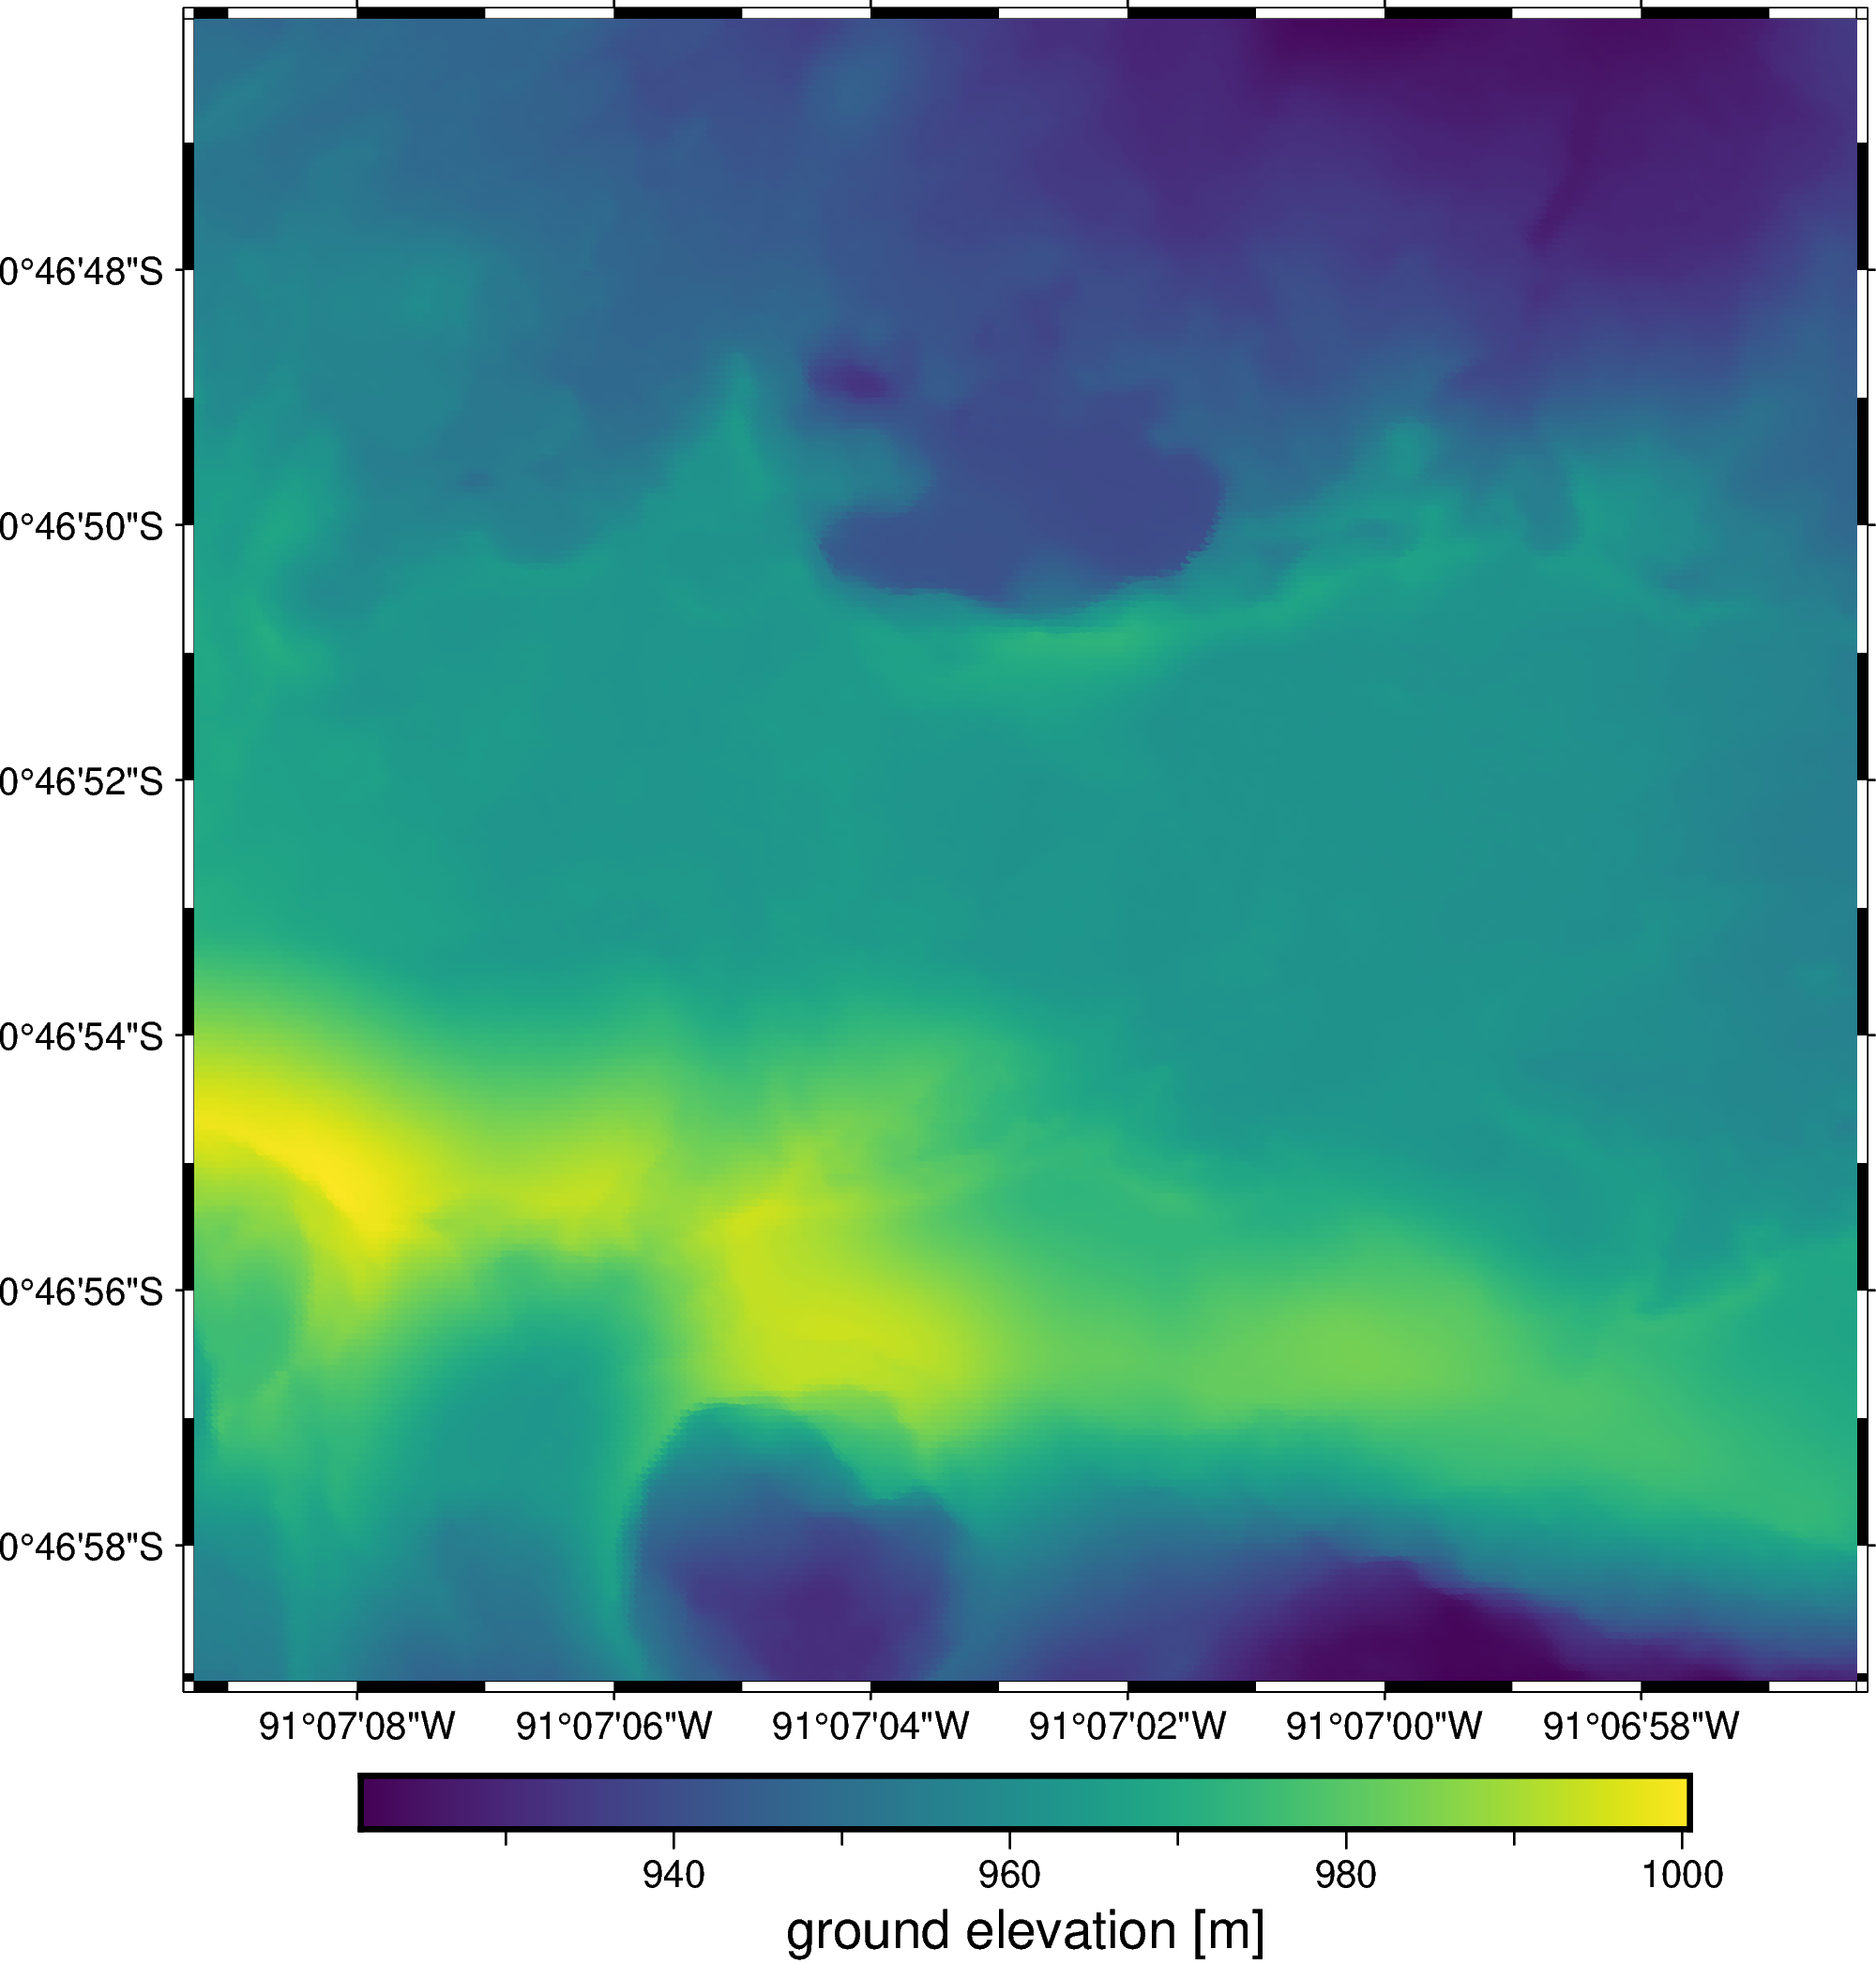

In [12]:
coordinates, elevation = blockmedian.filter((data_reloaded.longitude, data_reloaded.latitude), data_reloaded.elevation_m)

fig = pygmt.Figure()
fig.basemap(region=region, projection="M15c", frame=True)
pygmt.makecpt(cmap="viridis", series=[data.elevation_m.min(), data.elevation_m.max()])
fig.plot(
    x=coordinates[0], 
    y=coordinates[1], 
    color=elevation, 
    cmap=True, 
    style="c0.1c",
)
fig.colorbar(frame='af+l"ground elevation [m]"')
fig.show()